# Data imputation
In this notebook the inputation algorithms implemented are shown. This step is carried out in an Jupyter notebook with an R kernel available.

In [13]:
library(readr)
library(imputeTS)

In [14]:
#Imputation functions
source("../code/imputation_functions.R")
#Cross-validation functions
source('../code/imputation_functions.R')

## Testing with the Nortweast station
Here we are going to test the imputation algorithm with the Northwest station. 

In [3]:
station_data_path="../data/Monterrey/cleaned_station/NOROESTE.csv"

NOROESTE <- read_csv(station_data_path,
    col_types = cols(FECHA = col_datetime(format = "%Y-%m-%d %H:%M:%S")))
#View(NOROESTE)

In [4]:
str(NOROESTE)

Classes 'spec_tbl_df', 'tbl_df', 'tbl' and 'data.frame':	52608 obs. of  16 variables:
 $ FECHA: POSIXct, format: "2012-01-01 00:00:00" "2012-01-01 01:00:00" ...
 $ CO   : num  2.08 5.2 2.51 3.33 1.26 0.91 1.68 1.06 0.66 0.66 ...
 $ NO   : num  16.6 154.4 47.4 96.7 10 ...
 $ NO2  : num  57.8 60.4 51.1 49 39.3 27.4 40 23.1 14.9 12.7 ...
 $ NOX  : num  74.4 214.8 98.5 145.7 49.3 ...
 $ O3   : num  5 8 4 6 7 8 3 12 22 25 ...
 $ PM10 : num  300 255 433 216 212 110 86 131 206 64 ...
 $ PM2.5: num  NA NA NA NA NA NA NA NA NA NA ...
 $ PRS  : num  716 716 716 716 717 ...
 $ RAINF: num  0 0 0 0 0 0 0 0 0 0 ...
 $ RH   : num  31 34 34 34 28 25 29 33 34 37 ...
 $ SO2  : num  14.5 16.5 10.9 9.9 7.5 6.4 6.7 6.5 6.5 6.4 ...
 $ SR   : num  0 0 0 0 0 0 0 0.006 0.062 0.06 ...
 $ TOUT : num  18.6 17.6 17.1 17 17.8 ...
 $ WDR  : num  330 295 332 310 317 318 281 37 111 220 ...
 $ WSR  : num  6.8 2.4 5.3 8.1 11 11.8 5.1 14.6 6 9.1 ...
 - attr(*, "spec")=
  .. cols(
  ..   FECHA = col_datetime(format = "%Y-

In [5]:
tsNOROESTE<-ts(NOROESTE, start = c(2012,0), frequency = 365.25*24)
imputed <-Gerimputation("../data/Monterrey/cleaned_station/","NOROESTE")
#save(imputed, file="../data/Monterrey/processed/NOROESTE.RData") #the time series format get lost after saving.
#write.csv(cbind(NOROESTE[,1],imputed), file="../data/Monterrey/processed/NOROESTE.csv", row.names = FALSE)

In [6]:
# Time series object to dataframe (For plotting purposes and easy handling)
imputeddf<-data.frame(as.matrix(imputed),date=time(imputed))

In [7]:
for (var in colnames(imputeddf)[-16])
{
    test_missing<-which(is.na(tsNOROESTE[,var]))
    imputeddf[,paste(var,'_miss', sep="")]<-'Not missing'
    imputeddf[test_missing,paste(var,'_miss', sep="")]<-'Missing'
}

In [8]:
head(imputeddf)

CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,...,PM10_miss,PM2.5_miss,PRS_miss,RAINF_miss,RH_miss,SO2_miss,SR_miss,TOUT_miss,WDR_miss,WSR_miss
2.08,16.6,57.8,74.4,5,300,18.55240,715.8,0,31,...,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
5.20,154.4,60.4,214.8,8,255,21.62368,716.2,0,34,...,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
2.51,47.4,51.1,98.5,4,433,23.59464,716.5,0,34,...,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
3.33,96.7,49.0,145.7,6,216,33.93142,716.5,0,34,...,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
1.26,10.0,39.3,49.3,7,212,16.87847,716.7,0,28,...,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
0.91,6.2,27.4,33.6,8,110,18.43492,717.3,0,25,...,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing


In [9]:
write.csv(imputeddf, '../data/Monterrey/processed/northweast_imputations.csv')

## Creating partitions for cross validation

In [16]:
require(caret)
flds <- createFolds(NOROESTE, k = 10, list = TRUE, returnTrain = FALSE)

In [24]:
flds[5]

$Fold5
[1] 15

### Multiseasonal decomposition of PM2.5 

In [14]:
#Seasonalidad, diaria no capturada
imputeddecomposed <-decompose(imputed[,'PM2.5'])
#plot(imputeddecomposed)

In [15]:
str(imputeddecomposed)

List of 6
 $ x       : Time-Series [1:52608] from 2012 to 2018: 18.6 21.6 23.6 33.9 16.9 ...
 $ seasonal: Time-Series [1:52608] from 2012 to 2018: 16.53 35.5 10.56 3.38 4.22 ...
 $ trend   : Time-Series [1:52608] from 2012 to 2018: NA NA NA NA NA NA NA NA NA NA ...
 $ random  : Time-Series [1:52608] from 2012 to 2018: NA NA NA NA NA NA NA NA NA NA ...
 $ figure  : num [1:8766] 16.53 35.5 10.56 3.38 4.22 ...
 $ type    : chr "additive"
 - attr(*, "class")= chr "decomposed.ts"


In [16]:
library(ggfortify)
decomposedexpladf<- fortify(imputeddecomposed)

Warning message:
"package 'ggfortify' was built under R version 3.6.2"Loading required package: ggplot2
Registered S3 methods overwritten by 'ggfortify':
  method                 from    
  autoplot.Arima         forecast
  autoplot.acf           forecast
  autoplot.ar            forecast
  autoplot.bats          forecast
  autoplot.decomposed.ts forecast
  autoplot.ets           forecast
  autoplot.forecast      forecast
  autoplot.stl           forecast
  autoplot.ts            forecast
  fitted.ar              forecast
  fortify.ts             forecast
  residuals.ar           forecast


In [13]:
write.csv(decomposedexpladf, '../data/Monterrey/processed/northweast_pm5_decomposed.csv')

### Seasonal RAINF

In [15]:
#Seasonalidad, diaria no capturada
imputeddecomposed <-decompose(imputed[,'RAINF'])
library(ggfortify)
decomposedexpladf<- fortify(imputeddecomposed)
write.csv(decomposedexpladf, '../data/Monterrey/processed/northweast_RAINF_decomposed.csv')

### Visualize imputations

All the imputations for the northwest measurement station

In [9]:
library(ggplot2)
library(gridExtra)
library(grid)
library(lattice)

Warning message:
"package 'gridExtra' was built under R version 3.6.2"

In [10]:
co_plot <-ggplot(imputeddf, aes(x=date, y=CO, color=CO_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none", axis.title.x=element_text(face='plain',size=7), axis.text.x=element_text(face='plain',size=7))
no_plot <-ggplot(imputeddf, aes(x=date, y=NO, color=NO_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
no2_plot <-ggplot(imputeddf, aes(x=date, y=NO2, color=NO2_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
nox_plot <-ggplot(imputeddf, aes(x=date, y=NOX, color=NOX_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
o3_plot <-ggplot(imputeddf, aes(x=date, y=O3, color=O3_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
pm10_plot <-ggplot(imputeddf, aes(x=date, y=PM10, color=PM10_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
pm25_plot <-ggplot(imputeddf, aes(x=date, y=PM2.5, color=PM2.5_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
psr_plot <-ggplot(imputeddf, aes(x=date, y=PRS, color=PRS_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
rainf_plot <-ggplot(imputeddf, aes(x=date, y=RAINF, color=RAINF_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
rh_plot <-ggplot(imputeddf, aes(x=date, y=RH, color=RH_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
so2_plot <-ggplot(imputeddf, aes(x=date, y=SO2, color=SO2_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() +theme(legend.position = "none")
sr_plot <-ggplot(imputeddf, aes(x=date, y=SR, color=SR_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
tout_plot <-ggplot(imputeddf, aes(x=date, y=TOUT, color=TOUT_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
wdr_plot <-ggplot(imputeddf, aes(x=date, y=WDR, color=WDR_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
wsr_plot <-ggplot(imputeddf, aes(x=date, y=WSR, color=WSR_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to 

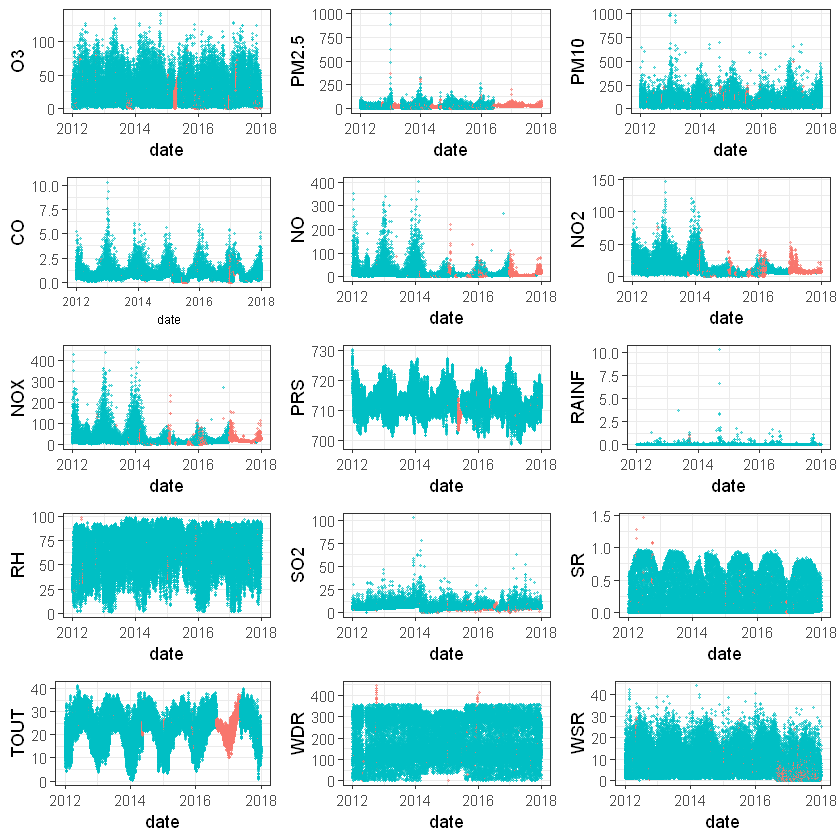

In [11]:
grid.arrange(o3_plot,pm25_plot,pm10_plot,co_plot,no_plot,no2_plot,nox_plot, psr_plot, rainf_plot, rh_plot, so2_plot, sr_plot, tout_plot, wdr_plot, wsr_plot, ncol=3)